In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5
(1080, 64, 64, 3)
(120, 64, 64, 3)
(1, 120)
(1, 1080)
[0 1 2 3 4 5]
[array([[5, 0, 2, ..., 2, 4, 5]], dtype=int64)]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]


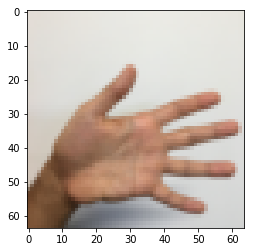

In [16]:

# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print(X_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)
print(Y_train_orig.shape)

print(classes)
print([Y_train_orig])
print(np.eye(6)[Y_train_orig.reshape(-1)].T)

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}
print(Y_train)

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)
[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


# 1.1 - Create placeholders


In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    return X, Y

# 1.2 - Initialize parameters


In [6]:
def initialize_parameters():
    tf.set_random_seed(1)
    #with tf.variable_scope("initialize_parameters", reuse=tf.AUTO_REUSE):
    W1 = tf.get_variable("W1",[4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

# 1.2 - Forward propagation


Implement the forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED.


In detail, we will use the following parameters for all the steps:
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - Flatten the previous output.
 - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 

In [7]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1,[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    Z2 = tf.nn.conv2d(P1,W2,[1,1,1,1],padding='SAME')
    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    return Z3

# 1.3 - Compute cost

In [8]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

# 1.4 Model


In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()  
    tf.set_random_seed(1)
    seed = 3   
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1] 
    
    costs = [] 
    
    X, Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
           
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                [_,temp_cost] = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += (temp_cost / num_minibatches)
                
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!");
               
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
              
        return train_accuracy, test_accuracy, parameters  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784094
Cost after epoch 30: 1.687814
Cost after epoch 35: 1.617914
Cost after epoch 40: 1.588563
Cost after epoch 45: 1.564673
Cost after epoch 50: 1.551985
Cost after epoch 55: 1.512204
Cost after epoch 60: 1.488463
Cost after epoch 65: 1.368796
Cost after epoch 70: 1

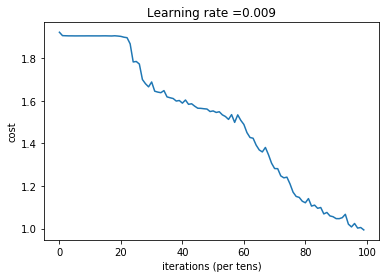

Parameters have been trained!
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.67314816
Test Accuracy: 0.53333336


In [10]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)